#Performance Comparison of Multiple Models on Different Datasets

source:https://github.com/Lexuz17/Kerala_Flood_Classification_Prediction.git

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import joblib

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display matplotlib plots inline
%matplotlib inline

# For classification models
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import Binarizer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# For model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

Upload the 'kerala.csv' and 'malaysia.csv'

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kerala.csv to kerala.csv
Saving malaysia.csv to malaysia.csv


In [3]:
# Prepare the 'kerala.csv' and 'malaysia.csv' datasets into a dataframe using pandas
floodData = pd.read_csv('kerala.csv')
mlsData = pd.read_csv('malaysia.csv')

In [4]:
# Perform label encoding to change the value yes to 1 and the value no to 0, so that it is easier to use for data analysis or modeling.
floodData['FLOODS'] = floodData['FLOODS'].replace({'YES': 1, 'NO': 0})
floodData = floodData.infer_objects(copy=False)

<ipython-input-4-130289939>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  floodData['FLOODS'] = floodData['FLOODS'].replace({'YES': 1, 'NO': 0})


In [5]:
# Remove all unnecessary spaces from the column names
floodData.columns = floodData.columns.str.strip()
print(floodData.columns)

mlsData.columns = mlsData.columns.str.strip()
print(mlsData.columns)

Index(['SUBDIVISION', 'YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL RAINFALL', 'FLOODS'],
      dtype='object')
Index(['STATE', 'DISTRICT', 'YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
       'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL RAINFALL', 'FLOOD'],
      dtype='object')


In [6]:
# Standardize column name in Kerala dataset to match
mlsData = mlsData.rename(columns={'FLOOD': 'FLOODS'})

#Number of flood and no-flood cases recorded

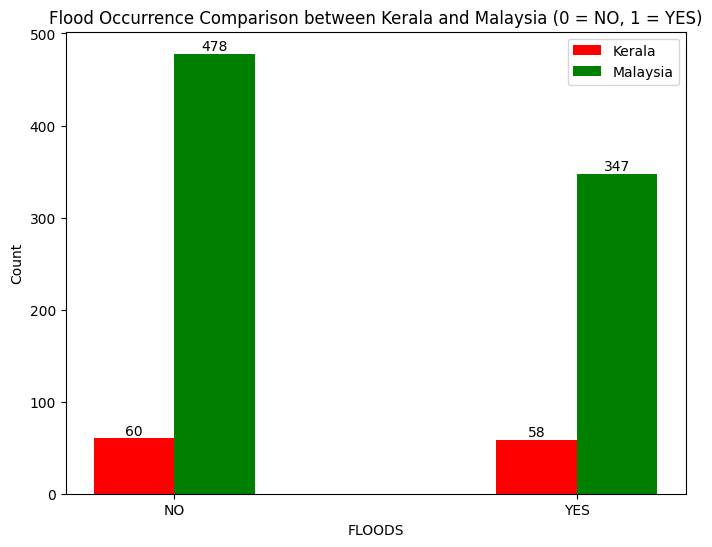

In [7]:
# Count values
kerala_counts = floodData['FLOODS'].value_counts()
malaysia_counts = mlsData['FLOODS'].value_counts()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set the bar width
width = 0.20  # Bar width
index = [0, 1]  # Flood occurrence values (0 = NO, 1 = YES)

# Plot the bar charts for both Kerala and Malaysia
ax.bar([i - width/2 for i in index], kerala_counts.values, width, label='Kerala', color='red')
ax.bar([i + width/2 for i in index], malaysia_counts.values, width, label='Malaysia', color='green')

# Add labels and title
ax.set_xlabel('FLOODS')
ax.set_ylabel('Count')
ax.set_title('Flood Occurrence Comparison between Kerala and Malaysia (0 = NO, 1 = YES)')
ax.set_xticks(index)
ax.set_xticklabels(['NO', 'YES'])
ax.legend()

# Add text annotations on top of the bars
for i, count in enumerate(kerala_counts.values):
    ax.text(i - width/2, count + 0.5, str(count), ha='center', va='bottom')

for i, count in enumerate(malaysia_counts.values):
    ax.text(i + width/2, count + 0.5, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

The plot of the number of floods and non-floods each year reveals that the data is complete and **relatively balanced**, with 60 flood data and 58 non-flood data for Kerala dataset. However, the Malaysia dataset is **imbalanced**, with a significant difference between the number of flood and non-flood records. Therefore, **SMOTE (Synthetic Minority Over-sampling Technique**) will be applied to the training data to address this imbalance before model training.

#Combine dataset





In [8]:
# Deleting the STATE and DISTRICT column
mlsData2 = mlsData.drop(columns=['STATE', 'DISTRICT'])

# Deleting the SUBDIVISION column to search for the corr heatmap
floodData2 = floodData.drop('SUBDIVISION', axis = 1)

In [9]:
# Add Location column to mark the dataset source
floodData2['Location'] = 'Kerala'
mlsData2['Location'] = 'Malaysia'

In [10]:
# Combine the datasets
combined_data = pd.concat([floodData2, mlsData2], axis=0)

In [11]:
# Ensuring that there is no null data
combined_data.isnull().sum()
# Ensuring that there is no Not a Number (NaN) data
combined_data.isna().any()

,0
YEAR,False
JAN,False
FEB,False
MAR,False
APR,False
MAY,False
JUN,False
JUL,False
AUG,False
SEP,False


In [12]:
# Convert 'Location' into numeric columns (e.g., Location_Kerala, Location_Malaysia)
combined_data_encoded = pd.get_dummies(combined_data, columns=['Location'], drop_first=True)
print(combined_data_encoded)

     YEAR     JAN     FEB     MAR     APR     MAY      JUN      JUL     AUG  \
0    1901   28.70   44.70   51.60  160.00  174.70   824.60   743.00  357.50   
1    1902    6.70    2.60   57.30   83.90  134.50   390.90  1205.00  315.80   
2    1903    3.20   18.60    3.10   83.60  249.70   558.60  1022.50  420.20   
3    1904   23.70    3.00   32.20   71.50  235.70  1098.20   725.50  351.80   
4    1905    1.20   22.30    9.40  105.90  263.30   850.20   520.50  293.60   
..    ...     ...     ...     ...     ...     ...      ...      ...     ...   
820  2006  319.70  427.23  196.89  255.44  247.38   235.60   113.64  188.40   
821  2007  525.34  278.92  189.47  202.96  231.20   393.88   302.34  162.90   
822  2008  410.77  283.12  372.34  231.40  222.25   239.34   200.40  310.88   
823  2009  726.05  272.96  254.93  280.74  203.49   186.64   133.75  198.65   
824  2010  545.47  211.71  237.34  187.18  278.18   198.32   370.80  327.32   

        SEP     OCT     NOV     DEC  ANNUAL RAINFAL

#Splitting data for Kerala

In [13]:
# Kerala data (Location_Malaysia == 0)
kerala_data = combined_data_encoded[combined_data_encoded['Location_Malaysia'] == 0]
# Malaysia data (Location_Malaysia == 1)
malaysia_data = combined_data_encoded[combined_data_encoded['Location_Malaysia'] == 1]

Modified: We use label-based selection for splitting label and features instead of position-based selection.

In [14]:
# For Kerala dataset,x is feature where y is label
X = kerala_data.drop('FLOODS', axis=1)
y = kerala_data['FLOODS']

# Train-test split for Kerala
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Check the shape of x_train and x_test
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)

# The data is well-separated with 94 and 24 samples, which total to 118 samples, which is the same as the original dataset.

X_train shape = (88, 15)
X_test shape = (30, 15)


#Splitting data for Malaysia

In [15]:
# For Malaysia dataset
X_malaysia = malaysia_data.drop('FLOODS', axis=1)
y_malaysia = malaysia_data['FLOODS']

# Train-test split for Malaysia
X_train_malaysia, X_test_malaysia, y_train_malaysia, y_test_malaysia = train_test_split(X_malaysia, y_malaysia, test_size=0.25, random_state=42)

#Apply SMOTE only on the Malaysia training set to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_malaysia_smote, y_train_malaysia_smote = smote.fit_resample(X_train_malaysia, y_train_malaysia)

#to check whether balance or not after using SMOTE
print(y_train_malaysia.value_counts())
print(y_train_malaysia_smote.value_counts())

FLOODS
0    364
1    254
Name: count, dtype: int64
FLOODS
0    364
1    364
Name: count, dtype: int64


In [16]:
# Check the shape of x_train and x_test
print("X_train_malaysia shape =", X_train_malaysia_smote.shape)
print("X_test_malaysia shape =", X_test_malaysia.shape)

X_train_malaysia shape = (728, 15)
X_test_malaysia shape = (207, 15)


#Splitting data for combine dataset

In [17]:
#For combined dataset
X_combine = combined_data_encoded.drop('FLOODS', axis=1)
y_combine = combined_data_encoded['FLOODS']

# Train-test split for combined dataset
X_train_combine, X_test_combine, y_train_combine, y_test_combine = train_test_split(X_combine, y_combine, test_size=0.25, random_state=42)

#Apply SMOTE only on the Malaysia training set to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_combine_smote, y_train_combine_smote = smote.fit_resample(X_train_combine, y_train_combine)

# To check whether balance or not after using SMOTE
print(y_train_combine.value_counts())
print(y_train_combine_smote.value_counts())

FLOODS
0    417
1    290
Name: count, dtype: int64
FLOODS
1    417
0    417
Name: count, dtype: int64


In [18]:
# Check the shape of x_train and x_test
print("X_train shape =", X_train_combine.shape)
print("X_test shape =", X_test_combine.shape)

X_train shape = (707, 15)
X_test shape = (236, 15)


#Preprocessing data

In [19]:
minmax = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()

Modified:We added full preprocessing steps for each dataset, including scaling and the use of a Binarizer for specific models.

In [20]:
# Scale Kerala data
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [21]:
# Scale Malaysia data
scaler_malaysia = minmax
X_train_malaysia_sc = scaler_malaysia.fit_transform(X_train_malaysia)
X_test_malaysia_sc = scaler_malaysia.transform(X_test_malaysia)

In [22]:
# Scale Malaysia data
scaler_malaysia = minmax
X_train_malaysia_scaled = scaler_malaysia.fit_transform(X_train_malaysia_smote)
X_test_malaysia_scaled = scaler_malaysia.transform(X_test_malaysia)

In [23]:
#Scale combined data
X_train_combine_sc = minmax.fit_transform(X_train_combine)
X_test_combine_scaled = minmax.transform(X_test_combine)
X_train_combine_scaled = minmax.fit_transform(X_train_combine_smote)

In [24]:
# Create a Binarizer that converts values greater than 75.0 to 1, and values less than or equal to 75.0 to 0
binarizer = Binarizer(threshold=75.0)

# Create a Binarizer that converts values greater than 200.0 to 1, and values less than or equal to 200.0 to 0
binarizer_mls= Binarizer(threshold=200.0)

In [25]:
#For Naive Bayes model
X_train_bin = binarizer.fit_transform(X_train) #for Kerala dataset
X_test_bin = binarizer.transform(X_test)

X_train_binarized = binarizer_mls.fit_transform(X_train_malaysia)  #for malaysia dataset
X_test_binarized = binarizer_mls.transform(X_test_malaysia)

X_train_combin = binarizer.fit_transform(X_train_combine)
X_test_combin = binarizer.transform(X_test_combine)

#Modelling for Kerala

##KNN classifier

Modified: Scaled training data is used instead of unscaled data and we use 5 folds for the cross-validation score.

In [26]:
model = neighbors.KNeighborsClassifier()
knn_model = model.fit(X_train_sc,y_train)

In [27]:
# Make predictions for x_test
y_predict = knn_model.predict(X_test_sc)

# Check the predict values
print('Predicted chances of flood')
print(y_predict)

# Check the actual values
print("actual values of floods:")
print(y_test.values)

Predicted chances of flood
[0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1]
actual values of floods:
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]


Calculate the accuracy score using k-fold cross-validation.

*   The `knn_model` uses the KNN model that was created previously.
*   The `cv=5` parameter specifies the number of folds, so in this case, there are 5 folds.
*   The `scoring='accuracy'` parameter specifies the accuracy score as the evaluation metric.


In [28]:
# Print the accuracy score after 5 folds
knn_accuracy = cross_val_score(knn_model, X_train_sc, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Print the average accuracy across 5-fold cross-validation
print('The accuracy score after 5 folds is:', knn_accuracy.mean())

# Evaluate the trained KNN model on the test set
test_accuracy = knn_model.score(X_test_sc, y_test)
print("Test accuracy:", test_accuracy)

The accuracy score after 5 folds is: 0.7954248366013073
Test accuracy: 0.9



Accuracy Score: 90.00%
Recall Score: 82.35%
ROC AUC Score: 91.18%


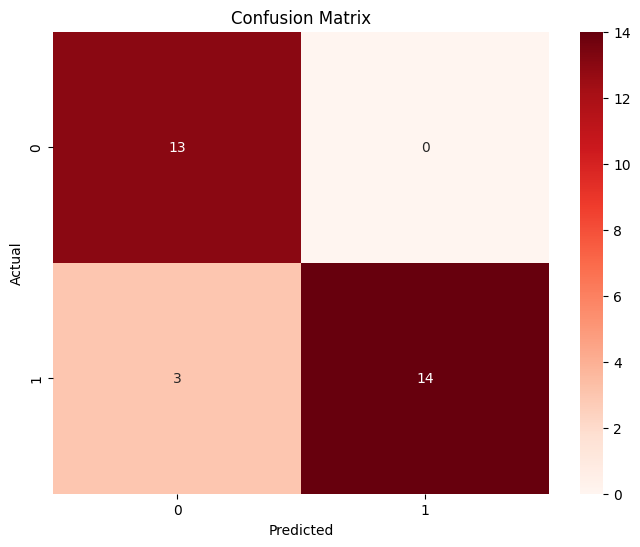

In [29]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test, y_predict) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test, y_predict) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test, y_predict) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix for the KNN model shows that there are:

* 13 true positives, meaning that the model correctly classified 13 data points as floods.
* 0 false positives, meaning that the model incorrectly classified 0 data points as floods.
* 3 false negative, meaning that the model incorrectly classified 3 data point as not a flood.
* 14 true negatives, meaning that the model correctly classified 14 data points as not floods.

Overall, the confusion matrix shows that the model is able to classify data with a high degree of accuracy.

##Logistic Regression

Modified: Standard scaler is used instead of minmax scaler and we use 5 folds for the cross-validation score.

In [30]:
lr = LogisticRegression(max_iter=1000)
lr_model = lr.fit(X_train_sc,y_train)

y_predict = lr_model.predict(X_test_sc)

print('Predicted chances of flood')
print(y_predict)

print('Actual chances of flood')
print(y_test.values)

Predicted chances of flood
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]
Actual chances of flood
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]


In [31]:
lr_accuracy = cross_val_score(lr_model,X_test_sc,y_test,cv=5,scoring='accuracy',n_jobs=-1)

print('The accuracy score after 5 folds is:', lr_accuracy.mean())

test_accuracy = lr_model.score(X_test_sc, y_test)
print("Test accuracy:", test_accuracy)

The accuracy score after 5 folds is: 0.9
Test accuracy: 1.0



Accuracy Score: 100.00%
Recall Score: 100.00%
ROC AUC Score: 100.00%


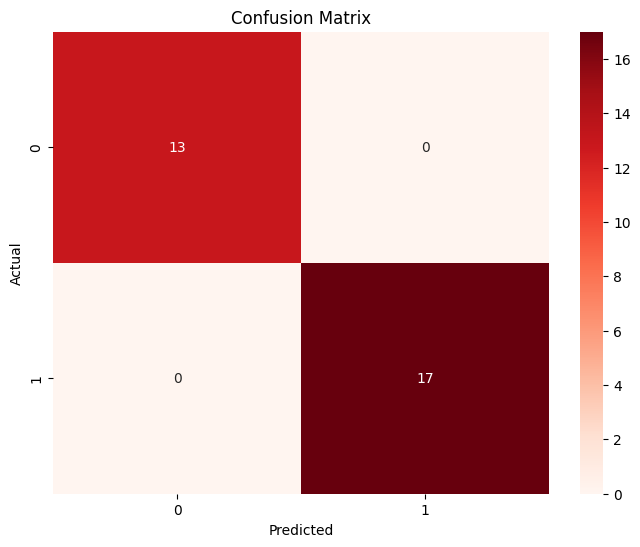

In [32]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test, y_predict) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test, y_predict) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test, y_predict) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##SVC(Support Vector Classifier)

Modified: Scaled training data is used instead of unscaled data and we use 5 folds for the cross-validation score.

In [33]:
svc = SVC(kernel='rbf',probability=True)
svc_model = svc.fit(X_train_sc,y_train)

y_predict=svc_model.predict(X_test_sc)

print("Actual Flood Values:")
print(y_test.values)

print("Predicted Flood Values:")
print(y_predict)

Actual Flood Values:
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]
Predicted Flood Values:
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1]


In [34]:
svc_acc = cross_val_score(svc_model,X_train_sc,y_train,cv=5,scoring="accuracy",n_jobs=-1)
print('The accuracy score after 5 folds is:', svc_acc.mean())

test_accuracy = svc_model.score(X_test_sc, y_test)
print('Test accuracy:', test_accuracy)

The accuracy score after 5 folds is: 0.9215686274509803
Test accuracy: 0.9666666666666667



Accuracy Score: 96.67%
Recall Score: 100.00%
ROC AUC Score: 96.15%


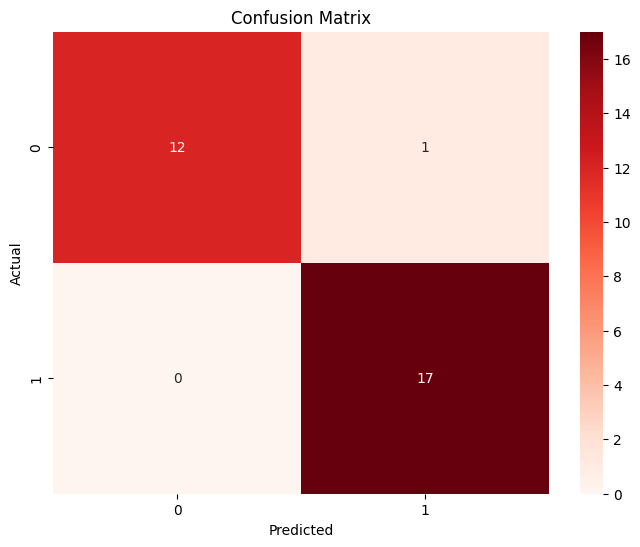

In [35]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test, y_predict) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test, y_predict) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test, y_predict) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Decision tree classification

Modified: Specific hyperparameter is applied to help prevent overfitting and we use 5 folds for the cross-validation score.

In [36]:
dtc = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
dtc_model = dtc.fit(X_train,y_train)

#Predict
y_predict = dtc_model.predict(X_test)

print('Predict values:')
print(y_predict)

#Actual flood chances
print("actual values:")
print(y_test.values)

Predict values:
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]
actual values:
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]


In [37]:
dtc_acc = cross_val_score(dtc_model,X_train,y_train,cv=5,scoring="accuracy",n_jobs=-1)
print('The accuracy score after 5 folds is:',dtc_acc.mean())

test_accuracy = dtc_model.score(X_test, y_test)
print('Test accuracy:', test_accuracy)

The accuracy score after 5 folds is: 0.9882352941176471
Test accuracy: 1.0



Accuracy Score: 100.00%
Recall Score: 100.00%
ROC AUC Score: 100.00%


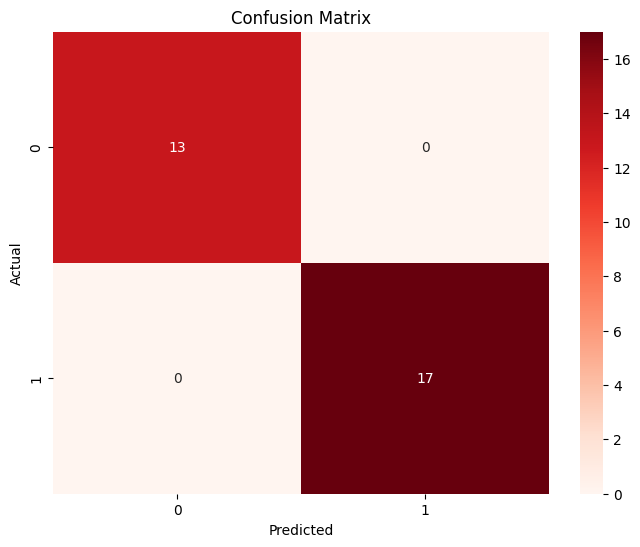

In [38]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test, y_predict) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test, y_predict) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test, y_predict) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Random Forest Classification

Modified: Specific hyperparameter is applied to help prevent overfitting and we use 5 folds for the cross-validation score.

In [39]:
rmf = RandomForestClassifier( n_estimators=100,
    max_depth=3,              # Limits how deep each tree can go
    min_samples_leaf=4,       # Minimum samples per leaf
    min_samples_split=10,     # Minimum samples to split a node
    max_features='sqrt',      # Limits number of features per tree
    random_state=42)
rmf_model = rmf.fit(X_train,y_train)

In [40]:
y_predict = rmf_model.predict(X_test)

print('Predict values:')
print(y_predict)

#Actual flood chances
print("actual values:")
print(y_test.values)

Predict values:
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]
actual values:
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]


In [41]:
rmf_acc = cross_val_score(rmf_model,X_train,y_train,cv=5,scoring="accuracy",n_jobs=-1)
print('The accuracy score after 5 folds is:',rmf_acc.mean())

test_accuracy = rmf_model.score(X_test, y_test)
print('Test accuracy:', test_accuracy)

The accuracy score after 5 folds is: 0.9882352941176471
Test accuracy: 1.0



Accuracy Score: 100.00%
Recall Score: 100.00%
ROC AUC Score: 100.00%


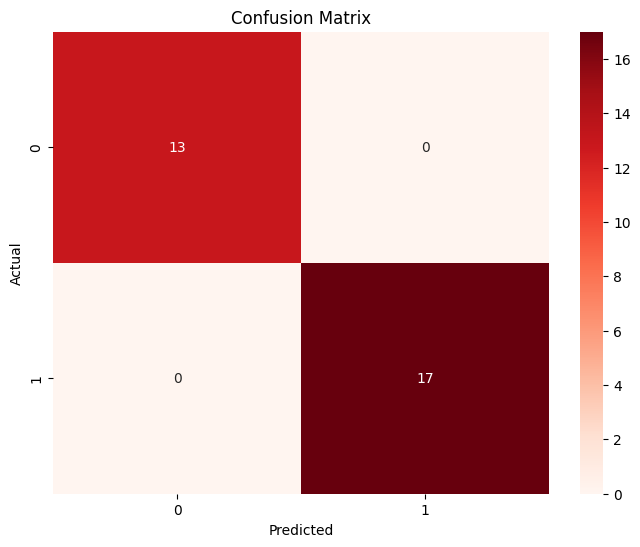

In [42]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test, y_predict) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test, y_predict) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test, y_predict) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Naive Bayes after using Binarizer

Modified:  Applied Binarizer preprocessing to transform continuous features into binary form and use 5 folds for the cross-validation score.

In [43]:
nb = BernoulliNB(force_alpha=True)
nb_model = nb.fit(X_train_bin,y_train)

In [44]:
y_predict=nb_model.predict(X_test_bin)

print("Actual Flood Values:")
print(y_test.values)

print("Predicted Flood Values:")
print(y_predict)

Actual Flood Values:
[1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1]
Predicted Flood Values:
[0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1]


In [45]:
nb_accuracy = cross_val_score(nb_model,X_train_bin,y_train,cv=5,scoring='accuracy',n_jobs=-1)
print('The accuracy score after 5 folds is:',nb_accuracy.mean())

test_accuracy = nb_model.score(X_test_bin, y_test)
print('Test accuracy:', test_accuracy)

The accuracy score after 5 folds is: 0.5470588235294118
Test accuracy: 0.6



Accuracy Score: 60.00%
Recall Score: 64.71%
ROC AUC Score: 59.28%


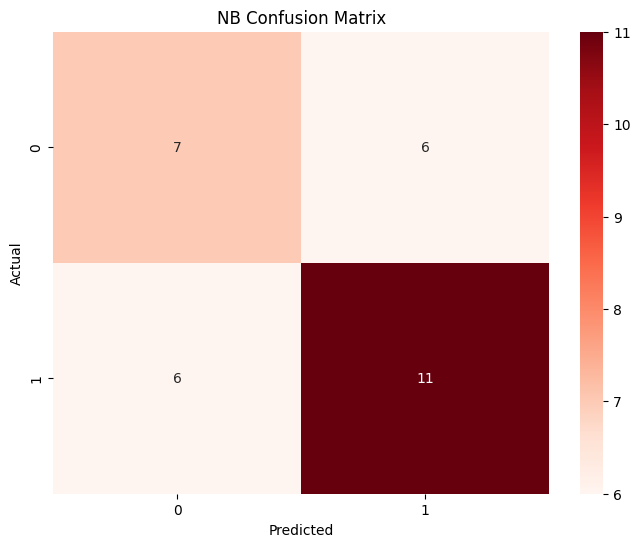

In [46]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test, y_predict) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test, y_predict) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test, y_predict) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('NB Confusion Matrix')
plt.show()

##Ensemble Learning

Modified: Used pipeline to combine preprocessing and model training and use 5 folds for the cross-validation score.

In [47]:
# Scaled pipelines
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
svc_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])

rf_model = RandomForestClassifier()

# Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('knn', knn_pipe),
        ('lr', lr_pipe),
        ('svc', svc_pipe),
        ('rf', rf_model)
    ],
    voting='soft'  # use 'hard' for majority vote
)

In [48]:
#fit model to training data
ensemble.fit(X_train, y_train)

#test our model on the test data
ensemble.score(X_test, y_test)


1.0

In [49]:
scores = cross_val_score(ensemble, X, y, cv=5)
print("CV Accuracy:", scores.mean())

CV Accuracy: 0.9239130434782608


#Modelling for Malaysia

The code below was added by us which is train and test for Malaysia dataset and Combined dataset, included performance comparison among models, and selected the best-performing model for prediction.

##KNN Classifier

In [50]:
model_malaysia = neighbors.KNeighborsClassifier()
knn_model_malaysia = model_malaysia.fit(X_train_malaysia_scaled,y_train_malaysia_smote)

In [51]:
# Make predictions for x_test
y_predict_malaysia = knn_model_malaysia.predict(X_test_malaysia_scaled)
print('Predicted chances of flood')
print(y_predict_malaysia)
# Check the actual values
print("actual values of floods:")
print(y_test_malaysia.values)

Predicted chances of flood
[1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0
 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1
 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0
 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0]
actual values of floods:
[1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0
 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1]


In [52]:
knn_accuracy1 = cross_val_score(knn_model_malaysia, X_train_malaysia_scaled, y_train_malaysia_smote, cv=5, scoring='accuracy', n_jobs=-1)
print('The accuracy score after 5 folds is:', knn_accuracy1.mean())

test_accuracy = knn_model_malaysia.score(X_test_malaysia_scaled, y_test_malaysia)
print("Test accuracy:", test_accuracy)

The accuracy score after 5 folds is: 0.6731695795937648
Test accuracy: 0.7294685990338164



Accuracy Score: 72.95%
Recall Score: 74.19%
ROC AUC Score: 73.06%


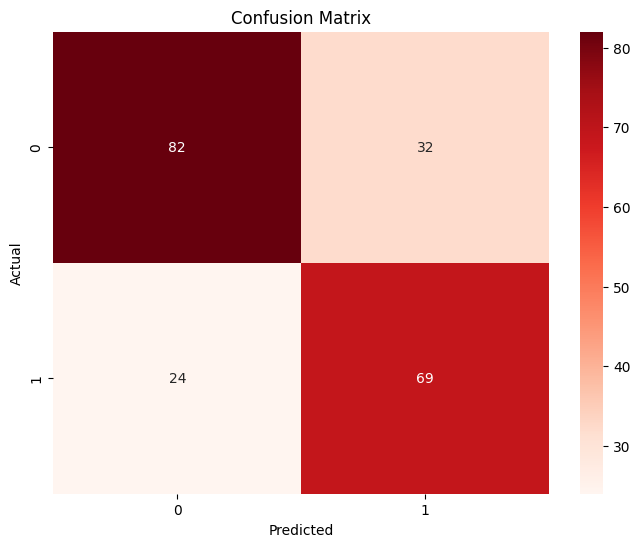

In [53]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test_malaysia, y_predict_malaysia) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test_malaysia, y_predict_malaysia) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test_malaysia, y_predict_malaysia) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test_malaysia, y_predict_malaysia)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Logistics Regression

In [54]:
lr_mls = LogisticRegression(max_iter=5000)
lr_model_mls = lr_mls.fit(X_train_malaysia_scaled,y_train_malaysia_smote)

In [55]:
y_predict_malaysia = lr_model_mls.predict(X_test_malaysia_scaled)

print('Predicted chances of flood')
print(y_predict_malaysia)

print('Actual chances of flood')
print(y_test_malaysia.values)

Predicted chances of flood
[0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1
 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1
 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1
 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1]
Actual chances of flood
[1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0
 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1]


In [56]:
lr_accuracy1 = cross_val_score(lr_model_mls,X_train_malaysia_scaled,y_train_malaysia_smote,cv=5,scoring='accuracy',n_jobs=-1)

print('The accuracy score after 5 folds is:', lr_accuracy1.mean())

test_accuracy = lr_model_mls.score(X_test_malaysia_scaled, y_test_malaysia)
print("Test accuracy:", test_accuracy)

The accuracy score after 5 folds is: 0.6304676428908834
Test accuracy: 0.6859903381642513



Accuracy Score: 68.60%
Recall Score: 65.59%
ROC AUC Score: 68.32%


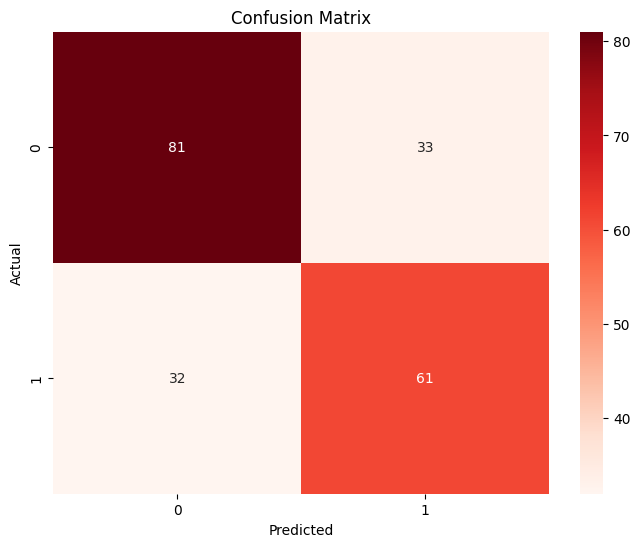

In [57]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test_malaysia, y_predict_malaysia) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test_malaysia, y_predict_malaysia) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test_malaysia, y_predict_malaysia) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test_malaysia, y_predict_malaysia)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##SVC

In [58]:
svc_mls = SVC(kernel='rbf',probability=True)
svc_model_mls = svc_mls.fit(X_train_malaysia_scaled,y_train_malaysia_smote)
y_predict_malaysia=svc_model_mls.predict(X_test_malaysia_scaled)

In [59]:
print("Actual Flood Values:")
print(y_test_malaysia.values)

print("Predicted Flood Values:")
print(y_predict_malaysia)

Actual Flood Values:
[1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0
 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1]
Predicted Flood Values:
[0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1
 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1
 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1
 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0
 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0
 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1]


In [60]:
svc_acc1 = cross_val_score(svc_model_mls,X_train_malaysia_scaled,y_train_malaysia_smote,cv=5,scoring="accuracy",n_jobs=-1)
print('The accuracy score after 5 folds is:', svc_acc1.mean())

test_accuracy = svc_model_mls.score(X_test_malaysia_scaled, y_test_malaysia)
print("Test accuracy:", test_accuracy)

The accuracy score after 5 folds is: 0.6758904109589041
Test accuracy: 0.6570048309178744



Accuracy Score: 65.70%
Recall Score: 68.82%
ROC AUC Score: 65.99%


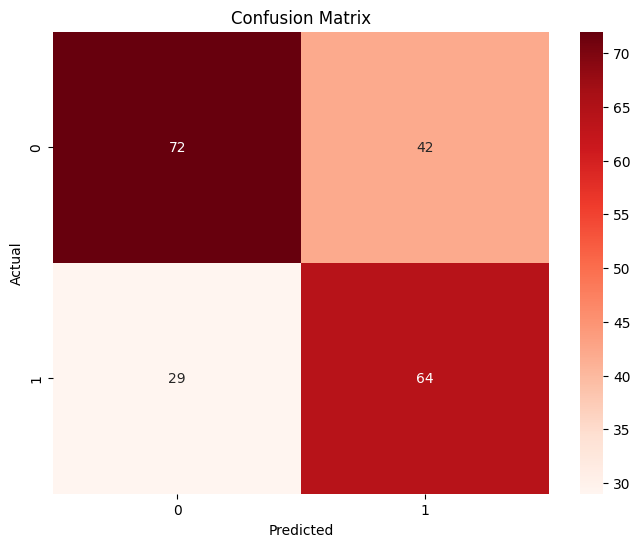

In [61]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test_malaysia, y_predict_malaysia) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test_malaysia, y_predict_malaysia) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test_malaysia, y_predict_malaysia) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test_malaysia, y_predict_malaysia)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Decision Tree Classification

In [62]:
dtc_mls = DecisionTreeClassifier(class_weight='balanced')
dtc_model_mls = dtc.fit(X_train_malaysia,y_train_malaysia)

In [63]:
y_predict_malaysia = dtc_model_mls.predict(X_test_malaysia)

print("Actual Flood Values:")
print(y_test_malaysia.values)

print("Predicted Flood Values:")
print(y_predict_malaysia)

Actual Flood Values:
[1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0
 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1]
Predicted Flood Values:
[1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1
 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1
 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0
 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0
 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1]


In [64]:
dtc_acc1 = cross_val_score(dtc_model,X_train_malaysia,y_train_malaysia,cv=5,scoring="accuracy",n_jobs=-1)
print('The accuracy score after 5 folds is:', dtc_acc1.mean())

test_accuracy = dtc_model_mls.score(X_test_malaysia, y_test_malaysia)
print("Test accuracy:", test_accuracy)

The accuracy score after 5 folds is: 0.5826252294781012
Test accuracy: 0.6086956521739131



Evaluation on test data:
Accuracy Score: 60.87%
Recall Score: 70.97%
ROC AUC Score: 61.80%


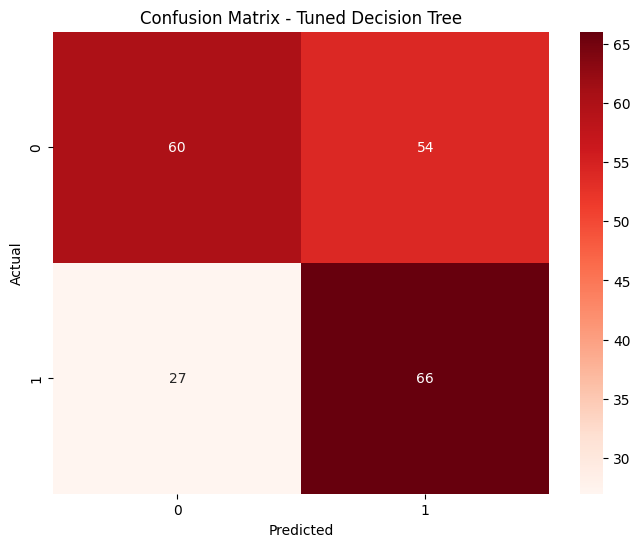

In [65]:
# Evaluation
print('\nEvaluation on test data:')
print('Accuracy Score: {:.2f}%'.format(accuracy_score(y_test_malaysia, y_predict_malaysia) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test_malaysia, y_predict_malaysia) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test_malaysia, y_predict_malaysia) * 100))

# Confusion matrix visualization
cm = confusion_matrix(y_test_malaysia, y_predict_malaysia)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Decision Tree')
plt.show()


##Random Forest Classification

In [66]:
rmf_mls = RandomForestClassifier(class_weight='balanced',max_depth=3,random_state=0)
rmf_model_mls = rmf_mls.fit(X_train_malaysia,y_train_malaysia)

In [67]:
y_predict_malaysia = rmf_model_mls.predict(X_test_malaysia)

print("Actual Flood Values:")
print(y_test_malaysia.values)

print("Predicted Flood Values:")
print(y_predict_malaysia)

Actual Flood Values:
[1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0
 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1]
Predicted Flood Values:
[0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1
 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1
 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0
 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0
 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1]


In [68]:
rmf_acc1 = cross_val_score(rmf_model_mls,X_train_malaysia,y_train_malaysia,cv=5,scoring="accuracy",n_jobs=-1)
print('The accuracy score after 5 folds is:', rmf_acc1.mean())

test_accuracy = rmf_model_mls.score(X_test_malaysia, y_test_malaysia)
print("Test accuracy:", test_accuracy)

The accuracy score after 5 folds is: 0.626304746918437
Test accuracy: 0.6521739130434783



Evaluation on test data:
Accuracy Score: 65.22%
Recall Score: 70.97%
ROC AUC Score (prob): 65.75%


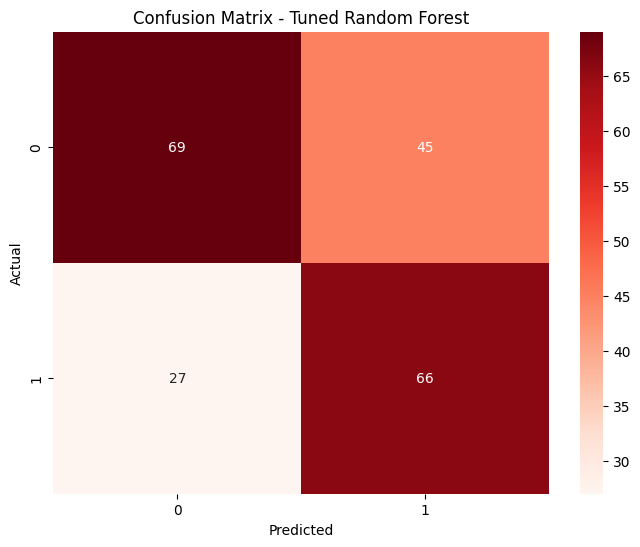

In [69]:
print('\nEvaluation on test data:')
print('Accuracy Score: {:.2f}%'.format(accuracy_score(y_test_malaysia, y_predict_malaysia) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test_malaysia, y_predict_malaysia) * 100))
print('ROC AUC Score (prob): {:.2f}%'.format(roc_auc_score(y_test_malaysia, y_predict_malaysia) * 100))

cm = confusion_matrix(y_test_malaysia, y_predict_malaysia)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.show()

##Naive Bayes

In [70]:
nb_mls = BernoulliNB(alpha=1.0)
nb_model_mls = nb_mls.fit(X_train_binarized, y_train_malaysia)

# instead of CV on the test set, do one hold-out accuracy:

In [71]:
y_predict_malaysia=nb_model_mls.predict(X_test_binarized)

print("Actual Flood Values:")
print(y_test_malaysia.values)

print("Predicted Flood Values:")
print(y_predict_malaysia)

Actual Flood Values:
[1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0
 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1]
Predicted Flood Values:
[0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1
 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1
 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0
 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0]


In [72]:
nb_accuracy1 = cross_val_score(nb_model_mls,X_train_binarized,y_train_malaysia,cv=5,scoring='accuracy',n_jobs=-1)
print('The accuracy score after 5 folds is:',nb_accuracy1.mean())

test_accuracy = nb_model_mls.score(X_test_binarized, y_test_malaysia)
print('Test accuracy:', test_accuracy)

The accuracy score after 5 folds is: 0.6265014424337793
Test accuracy: 0.6183574879227053



Accuracy Score: 61.84%
Recall Score: 43.01%
ROC AUC Score: 60.10%


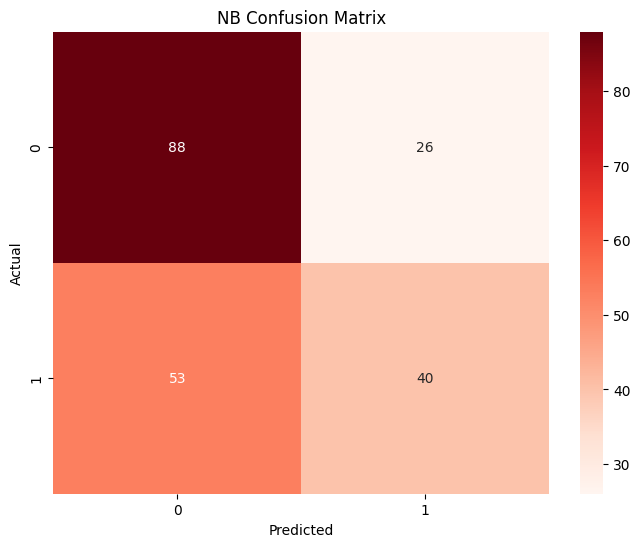

In [73]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test_malaysia, y_predict_malaysia) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test_malaysia, y_predict_malaysia) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test_malaysia, y_predict_malaysia) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test_malaysia, y_predict_malaysia)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('NB Confusion Matrix')
plt.show()

##Ensemble Learning

In [74]:
# Scaled pipelines
knn_pipe_mls = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
lr_pipe_mls = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
svc_pipe_mls = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))])

# Ensemble
ensemble1 = VotingClassifier(
    estimators=[
        ('knn', knn_pipe_mls),
        ('lr', lr_pipe_mls),
        ('svc', svc_pipe_mls),
        ('rf', rmf_model_mls)
    ],
    voting='soft'  # use 'hard' for majority vote
)

In [75]:
#fit model to training data
ensemble1.fit(X_train_malaysia, y_train_malaysia)

#test our model on the test data
ensemble1.score(X_test_malaysia, y_test_malaysia)

0.6618357487922706

In [76]:
scores = cross_val_score(ensemble1, X_train_malaysia, y_train_malaysia, cv=5)
print("CV Accuracy:", scores.mean())

CV Accuracy: 0.6165093102543928


##Comparison


In [77]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('LR',lr_model ))
models.append(('SVC',svc_model))
models.append(('DT', dtc_model))
models.append(('RF', rmf_model))
models.append(('NB', BernoulliNB()))
models.append(('EL', ensemble))

namaModel = []
hasilModel = []

# Train and test the models
for name, model in models:
    if name == 'LR' or name == 'SVC' or name == 'KNN':  # LR models use standardized data
        model.fit(X_train_sc, y_train)
        y_predict = model.predict(X_test_sc)
    elif name == 'NB':
        # FIXED: use binarized data and original labels
        model.fit(X_train_bin, y_train)
        y_predict = model.predict(X_test_bin)
    else:
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)

    hasilModel.append(accuracy_score(y_test, y_predict))
    namaModel.append(name)

tr_split = pd.DataFrame({'Name': namaModel, 'Score': hasilModel})
print(tr_split)

  Name     Score
0  KNN  0.900000
1   LR  1.000000
2  SVC  0.966667
3   DT  1.000000
4   RF  1.000000
5   NB  0.600000
6   EL  1.000000


In [78]:
models1 = []
models1.append(('KNN', KNeighborsClassifier()))
models1.append(('LR',lr_model_mls ))
models1.append(('SVC',svc_model_mls))
models1.append(('DT', dtc_model_mls))
models1.append(('RF', rmf_model_mls))
models1.append(('NB', BernoulliNB()))
models1.append(('EL', ensemble1))

namaModel = []
hasilModel = []

# Train and test the models
for name, model1 in models1:
    if name == 'LR' or name == 'SVC' or name == 'KNN':  # LR models use standardized data
        model1.fit(X_train_malaysia_scaled, y_train_malaysia_smote)
        y_predict_mls = model1.predict(X_test_malaysia_scaled)
    elif name == 'NB':
        # FIXED: use binarized data and original labels
        model1.fit(X_train_binarized, y_train_malaysia)
        y_predict_mls = model1.predict(X_test_binarized)
    else:
        model1.fit(X_train_malaysia, y_train_malaysia)
        y_predict_mls = model1.predict(X_test_malaysia)

    hasilModel.append(accuracy_score(y_test_malaysia, y_predict_mls))
    namaModel.append(name)

tr_split_mls = pd.DataFrame({'Name': namaModel, 'Score': hasilModel})
print(tr_split_mls)

  Name     Score
0  KNN  0.729469
1   LR  0.685990
2  SVC  0.657005
3   DT  0.608696
4   RF  0.652174
5   NB  0.618357
6   EL  0.657005


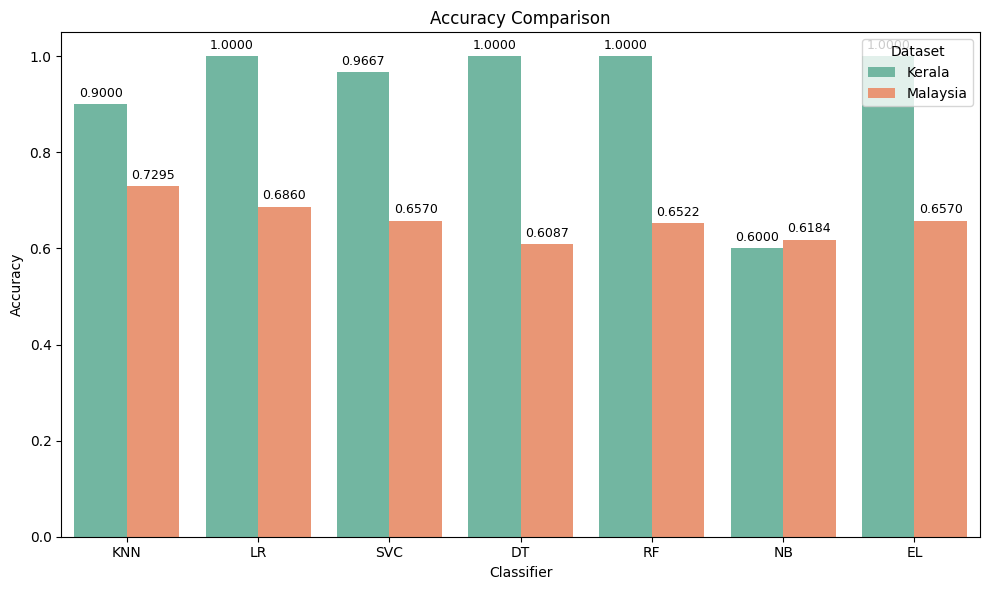

In [79]:
# Step 1: Add a label for each dataset
tr_split['Dataset'] = 'Kerala'
tr_split_mls['Dataset'] = 'Malaysia'
# Step 2: Combine both into one DataFrame
combined_plot = pd.concat([tr_split, tr_split_mls], ignore_index=True)
plt.figure(figsize=(10, 6))
axis = sns.barplot(x='Name', y='Score', hue='Dataset', data=combined_plot, palette='Set2')

# Add accuracy labels on top of each bar
for i, p in enumerate(axis.patches[:len(combined_plot)]):
    height = p.get_height()
    # Set a minimum height for zero bars to make the label visible
    label_y = height + 0.01 if height > 0 else 0.03
    axis.text(
        p.get_x() + p.get_width() / 2,
        label_y,
        '{:1.4f}'.format(height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
# Label and formatting
axis.set(xlabel='Classifier', ylabel='Accuracy', title='Accuracy Comparison')

# Fix y-axis to give enough room at the bottom
axis.set_ylim(0, 1.05)

plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

We will select the **top 3** highest-performing models to train, test, and evaluate combination of Kerala and Malaysia dataset which is KNN Classifier, logistics regression and ensemble learning.

#Modelling for combination

##KNN Classifier

In [80]:
model_combine = neighbors.KNeighborsClassifier()
knn_model_com = model_combine.fit(X_train_combine_scaled,y_train_combine_smote)

In [81]:
# Make predictions for x_test
y_predict_combine = knn_model_com.predict(X_test_combine_scaled)

print('Predicted chances of flood')
print(y_predict_combine)

# Check the actual values
print("actual values of floods:")
print(y_test_combine.values)

Predicted chances of flood
[1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0
 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0
 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0
 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 1 0]
actual values of floods:
[1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0
 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1
 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0
 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1
 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0
 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1
 0 1 0 1 0 1 1 1 1

In [82]:
knn_accuracy_com = cross_val_score(knn_model_com, X_train_combine_scaled, y_train_combine_smote, cv=5, scoring='accuracy', n_jobs=-1)
print('The accuracy score after 5 folds is:', knn_accuracy_com.mean())

test_accuracy_com = knn_model_com.score(X_test_combine_scaled, y_test_combine)
print("Test accuracy:", test_accuracy_com)

The accuracy score after 5 folds is: 0.7242478897626434
Test accuracy: 0.6567796610169492



Accuracy Score: 65.68%
Recall Score: 64.10%
ROC AUC Score: 65.66%


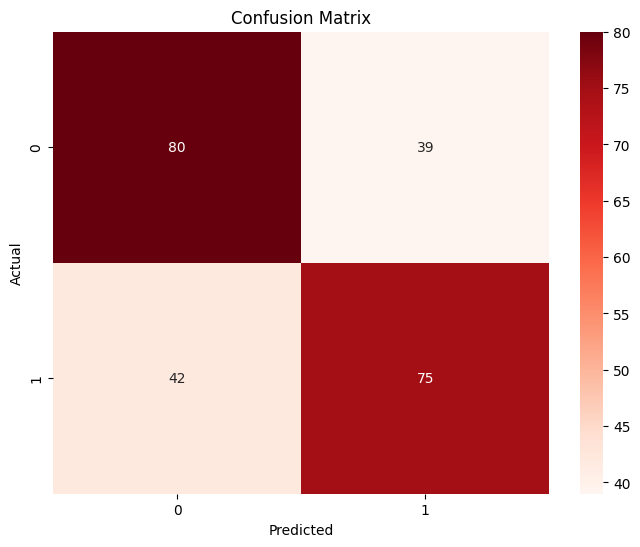

In [83]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test_combine, y_predict_combine) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test_combine, y_predict_combine) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test_combine, y_predict_combine) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test_combine, y_predict_combine)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Logistics Regression

In [84]:
lr_com = LogisticRegression(max_iter=1000)
lr_model_com = lr_com.fit(X_train_combine_scaled,y_train_combine_smote)

In [85]:
y_predict_com = lr_model_com.predict(X_test_combine_scaled)

print('Predicted chances of flood')
print(y_predict_com)

print('Actual chances of flood')
print(y_test_combine.values)

Predicted chances of flood
[1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0
 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0
 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1
 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0
 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0
 0 0 0 0 1 1 1 1 1 1 0 1 0 0]
Actual chances of flood
[1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0
 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1
 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0
 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1
 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0
 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1
 0 1 0 1 0 1 1 1 1 

In [86]:
lr_accuracy_com = cross_val_score(lr_model_com,X_train_combine_scaled,y_train_combine_smote,cv=5,scoring='accuracy',n_jobs=-1)
print('The accuracy score after 5 folds is:', lr_accuracy_com.mean())

test_accuracy = lr_model_com.score(X_test_combine_scaled, y_test_combine)
print('Test accuracy:', test_accuracy)

The accuracy score after 5 folds is: 0.5431426304018468
Test accuracy: 0.559322033898305



Accuracy Score: 55.93%
Recall Score: 55.56%
ROC AUC Score: 55.93%


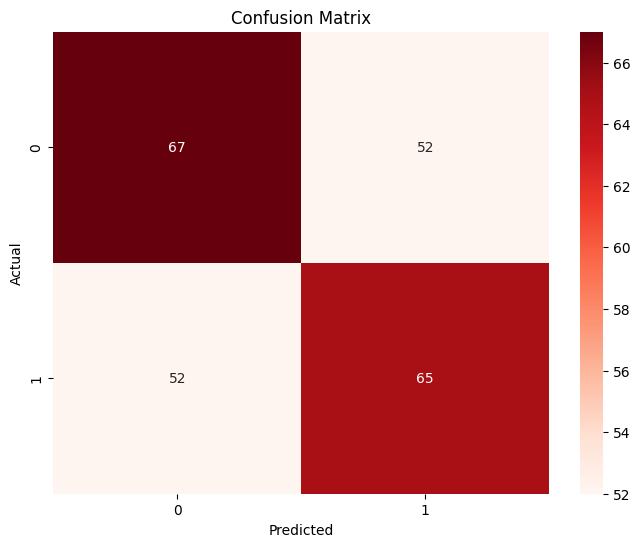

In [87]:
print('\nAccuracy Score: {:.2f}%'.format(accuracy_score(y_test_combine, y_predict_com) * 100))
print('Recall Score: {:.2f}%'.format(recall_score(y_test_combine, y_predict_com) * 100))
print('ROC AUC Score: {:.2f}%'.format(roc_auc_score(y_test_combine, y_predict_com) * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test_combine, y_predict_com)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Ensemble Learning

In [88]:
feature_names = X.columns.tolist()  # your original column names
X_train_combine_df = pd.DataFrame(X_train_combine, columns=feature_names)
X_test_combine_df = pd.DataFrame(X_test_combine, columns=feature_names)

# Scaled pipelines
knn_pipe_com = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
lr_pipe_com = Pipeline([('scaler', MinMaxScaler()), ('lr', LogisticRegression())])
svc_pipe_com = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(probability=True))])
rf_pipe_com = Pipeline([('identity', 'passthrough'), ('rf', RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=0))])


rmf_com = RandomForestClassifier(class_weight='balanced',max_depth=3,random_state=0)

# Ensemble
ensemble_com = VotingClassifier(
    estimators=[
        ('knn', knn_pipe_com),
        ('lr', lr_pipe_com),
        ('svc', svc_pipe_com),
        ('rf', rf_pipe_com)
    ],
    voting='soft'  # use 'hard' for majority vote
)

In [89]:
# Fit model to training data
ensemble_com.fit(X_train_combine_df, y_train_combine)


# Test our model on the test data
score_com = pd.DataFrame(
    {'Dataset': ['Combined'], 'Accuracy': [ensemble_com.score(X_test_combine_df, y_test_combine)]}
)
print(score_com)

    Dataset  Accuracy
0  Combined  0.635593


In [90]:
# Test our model on the malaysia test data
score_mls = pd.DataFrame(
    {'Dataset': ['Malaysia'], 'Accuracy': [ensemble_com.score(X_test_malaysia, y_test_malaysia)]}
)
print(score_mls)

    Dataset  Accuracy
0  Malaysia   0.73913


In [91]:
# Test our model on the kerala test data
score_kerala = pd.DataFrame(
    {'Dataset': ['Kerala'], 'Accuracy': [ensemble_com.score(X_test, y_test)]}
)
print(score_kerala)

  Dataset  Accuracy
0  Kerala       0.9


In [92]:
scores = cross_val_score(ensemble_com, X_train_combine_df, y_train_combine, cv=5)
print("CV Accuracy:", scores.mean())

CV Accuracy: 0.6618419738287884


In [93]:
# Save model to pkl file
joblib.dump(ensemble_com, 'ensemble_model.pkl')

from google.colab import files
files.download('ensemble_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Accuracy Comparison

In [94]:
models2 = []
models2.append(('KNN', KNeighborsClassifier()))
models2.append(('LR',lr_model_com ))
models2.append(('EL', ensemble_com))

namaModel = []
hasilModel = []

# Train and test the models
for name, model2 in models2:
    if name == 'LR' or name == 'KNN':  # LR models use standardized data
        model2.fit(X_train_combine_scaled, y_train_combine_smote)
        y_predict_com = model2.predict(X_test_combine_scaled)
    else:
        model2.fit(X_train_combine_sc, y_train_combine)
        y_predict_com = model2.predict(X_test_combine_scaled)

    hasilModel.append(accuracy_score(y_test_combine, y_predict_com))
    namaModel.append(name)

tr_split_com = pd.DataFrame({'Name': namaModel, 'Score': hasilModel})
print(tr_split_com)

  Name     Score
0  KNN  0.656780
1   LR  0.559322
2   EL  0.635593


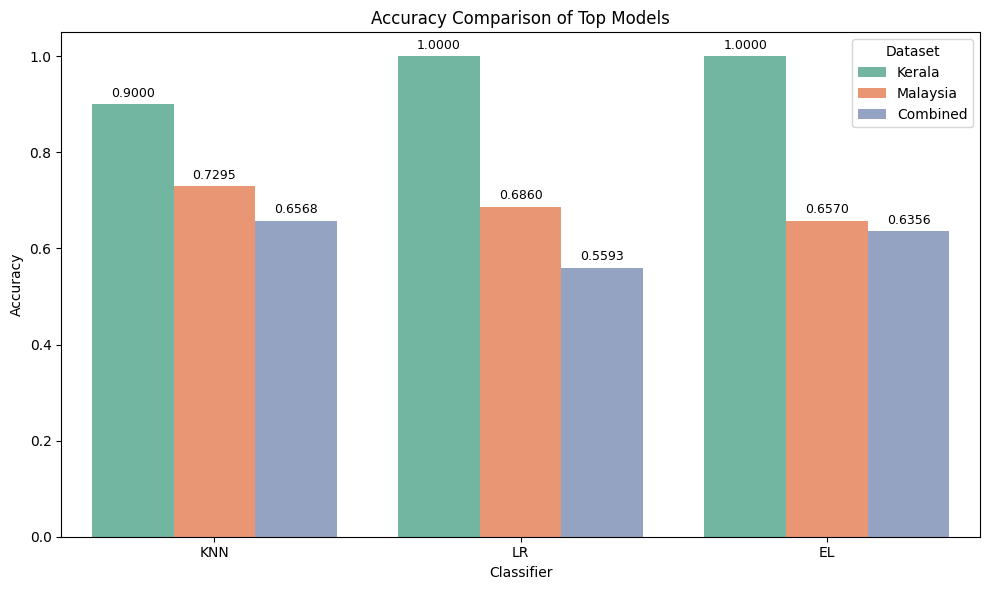

In [95]:
# Step 1: Add a label for each dataset
tr_split['Dataset'] = 'Kerala'
tr_split_mls['Dataset'] = 'Malaysia'
tr_split_com['Dataset'] = 'Combined'

# Step 2: Combine both into one DataFrame
combined_plot = pd.concat([tr_split, tr_split_mls, tr_split_com], ignore_index=True)

# Filter to only KNN, LR, and EL
combined_plot = combined_plot[combined_plot['Name'].isin(['KNN', 'LR', 'EL'])]

combined_plot['Score'] = pd.to_numeric(combined_plot['Score'], errors='coerce')
# Optionally drop rows with missing or zero scores
combined_plot = combined_plot[combined_plot['Score'] > 0]


# Plot
plt.figure(figsize=(10, 6))
axis = sns.barplot(x='Name', y='Score', hue='Dataset', data=combined_plot, palette='Set2')

# Add accuracy labels
for p in axis.patches:
    height = p.get_height()
    if height > 0:
        axis.text(
            p.get_x() + p.get_width() / 2,
            height + 0.01,
            '{:.4f}'.format(height),
            ha='center',
            va='bottom',
            fontsize=9
        )

# Label and formatting
axis.set(xlabel='Classifier', ylabel='Accuracy', title='Accuracy Comparison of Top Models')
axis.set_ylim(0, 1.05)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


From the three models, we will proceed with Ensemble Learning for our flood prediction task. Although the model achieves perfect accuracy on the Kerala dataset, we recognize that the dataset is relatively small, and such results may indicate potential overfitting. Therefore, our decision is based on its performance on the larger Malaysia dataset and the Combined dataset. It shows stable accuracy on the Malaysia data, and the accuracy doesn’t drop much when we combine the datasets, which means it generalizes well and is reliable.



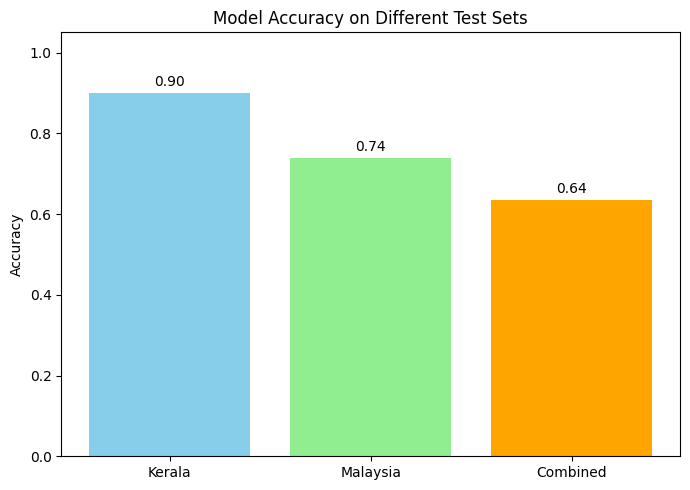

In [96]:
test_scores = pd.DataFrame({
    'Dataset': ['Kerala', 'Malaysia', 'Combined'],
    'Accuracy': [
        score_kerala['Accuracy'][0],score_mls['Accuracy'][0],score_com['Accuracy'][0]
    ]
})

# Plotting
plt.figure(figsize=(7, 5))
bars = plt.bar(test_scores['Dataset'], test_scores['Accuracy'], color=['skyblue', 'lightgreen', 'orange'])

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.ylim(0, 1.05)
plt.title('Model Accuracy on Different Test Sets')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

The bar chart illustrates the accuracy of the ensemble model across three different test datasets: Kerala, Malaysia, and the Combined dataset. The model trained on diverse dataset but still can perform strongly on each individual region. This means the model can work well even with different types of data.